In [1]:
import pickle
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import itertools

from pathlib import Path

In [2]:
from experiments import run_experiments

# The Data
## Log-Normal Distribution
In order to simulate an annoying real-world distribution, I used the log-normal distribution and rounded the results

This causes a large number of uniques, but with heavy-hitters and several lower probability uniques that still show up several times

## Sample Random Seed
To generate the same sample on several runs, I just used my id as the random seed.

## Sample size
I choose to use 200,000 (2e5) samples, since it's a nice round number.


In [3]:
X = lognorm.rvs(5, size=int(2e5), random_state=206783441).astype(int)

## Number of unique values
With the chosen seed I got 12147 unique values - which matches the criteria of 10k uniques

In [4]:
np.unique(X).shape

(12147,)

## How the distributions looks
We can see what I mean - many heavy hitters close to 0, but plenty of uniques

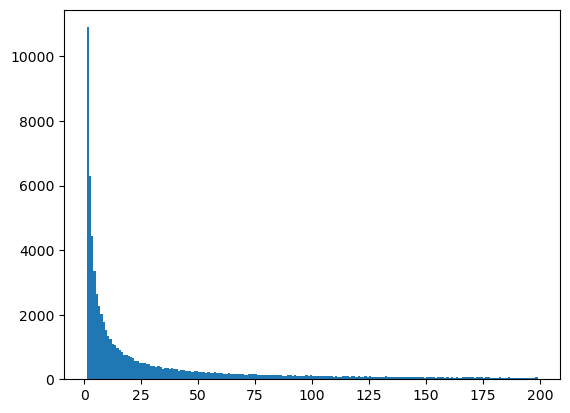

In [5]:
plt.hist(X, bins=np.arange(1, 200))
plt.show()

# Experiments


## The pre-processing trick
In order to save myself time, I decided to calculate the minimal hash value for 100,000 different unique random seeds,\
which then allows me to 'run' fm without much cost with hash functions matching those seeds.

In [6]:
min_hashes_dict: dict[int, float] = pickle.loads(Path('min_hashes_dict.pkl').read_bytes())

## Parameters
I ran 100 different experiments for each estimator and config, with the seeds being the values 1 to 100 for each one.

I used the seed to init the random hash function (the way it works is further elaborated in the file `experiments.py`) and besides that everthing else is deterministic

## Single $\alpha$ estimator
Here I could use the fact that I already have 100,000 min hashes to run 100,000 experiments with a single $\alpha$ estimator - so why not?

In [7]:
alpha_results = [1.0 / v for v in min_hashes_dict.values()]

### The results
We can already see that median is really far from the actual value (around 5000 off)

In [8]:
np.median(alpha_results)

np.float64(17798.525583497176)

The mean is even worse, most likely due to outliers (as we'll see later)

In [9]:
np.mean(alpha_results)

np.float64(216280.76118170455)

The normalized variance is also insane - it's more than 9 billion

In [10]:
np.var(alpha_results) / len(np.unique(X))

np.float64(9435443748.274153)

when we plot a histogram of the values with the actual number of uniques, the mean, and the median - we can see that they are not even close!

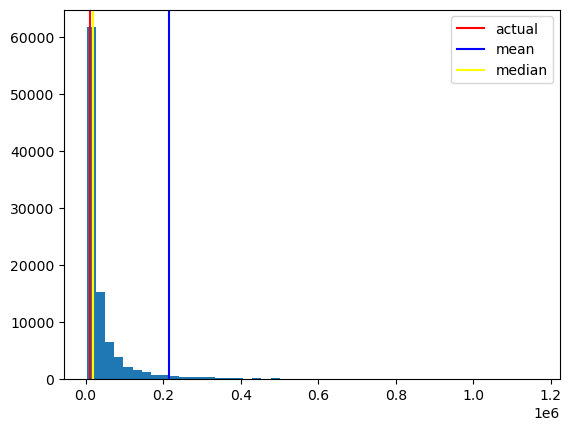

In [11]:
plt.hist(alpha_results, bins=np.linspace(np.quantile(alpha_results, 0.01), np.quantile(alpha_results, 0.99)))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

If we zoom in a bit, we can see that the median has most values around it, while the actual value is the **36th percentile!**

In [12]:
np.mean(np.array(alpha_results) <= len(np.unique(X)))

np.float64(0.36689)

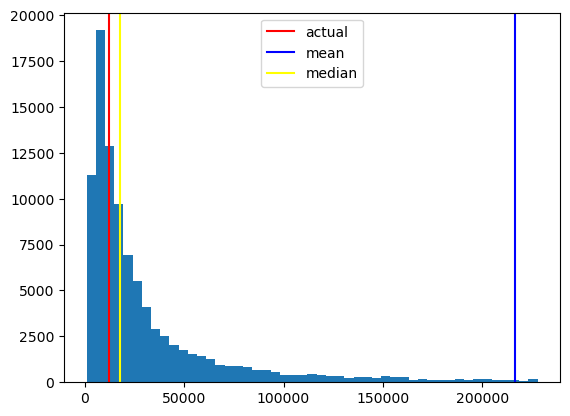

In [13]:
bins = np.linspace(np.min(alpha_results), np.quantile(alpha_results, .95)).tolist()
plt.hist(alpha_results, bins=sorted(bins))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

this shows that as we learned at class, the $\alpha$ estimator has way too much variance to be used as is

## Single $\beta$ estimator
Here I ran a full FM estimator with a several hash functions and a single $\beta$ estimator - which is just a $\beta$ estimator

For the beta estimator, I ran the same number of experiments with the following sketch sizes matching values of $\epsilon$ and $\delta$:
| $\delta$           | $\epsilon$     | sketch size |
|--------------------|----------------|-------------|
| 0.50 | 0.25 | 32 |
| 0.33 | 0.25 | 48 |
| 0.50 | 0.20 | 50 |
| 0.25 | 0.25 | 64 |
| 0.33 | 0.20 | 75 |
| 0.20 | 0.25 | 80 |
| 0.25 | 0.20 | 100 |
| 0.20 | 0.20 | 125 |
| 0.10 | 0.25 | 160 |
| 0.50 | 0.10 | 200 |
| 0.10 | 0.20 | 250 |
| 0.33 | 0.10 | 300 |
| 0.05 | 0.25 | 320 |
| 0.25 | 0.10 | 400 |
| 0.20 | 0.10 | 500 |
| 0.50 | 0.05 | 800 |
| 0.10 | 0.10 | 1000 |
| 0.10 | 0.089 | 1250 |
| 0.10 | 0.081 | 1500 |
| 0.10 | 0.075| 1750 |
| 0.10 | 0.070 | 2000 |
| 0.10 | 0.063 | 2500 |

In [14]:
beta_sketch_sizes = [32, 48, 50, 64, 75, 80, 100, 125, 160, 200, 250, 300, 320, 400, 500, 800, 1000, 1250, 1500, 1750, 2000, 2500]

### Other Parameters
In this case I ran 100 experiments per sketch size so that I could better compare the results

In [15]:
def beta_experiment(experiment_seed: int, num_hash_funcs: int) -> float:
    return float(1.0 / np.mean([min_hashes_dict[i + experiment_seed * num_hash_funcs] for i in range(num_hash_funcs)])  - 1)

In [16]:
beta_results = {
    sketch_size: [beta_experiment(base_seed, sketch_size) for base_seed in range(len(min_hashes_dict) // sketch_size)]
    for sketch_size in beta_sketch_sizes
}

In [17]:
[f'{n_hashes=}: median={float(np.median(b_res))}, diff={abs(float(np.median(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: median=12578.846559131318, diff=431.8465591313179',
 'n_hashes=48: median=12463.748509258907, diff=316.7485092589068',
 'n_hashes=50: median=12376.647150316203, diff=229.6471503162029',
 'n_hashes=64: median=12422.588545695242, diff=275.5885456952419',
 'n_hashes=75: median=12371.289484840796, diff=224.28948484079592',
 'n_hashes=80: median=12414.998069235171, diff=267.998069235171',
 'n_hashes=100: median=12349.874214392694, diff=202.87421439269383',
 'n_hashes=125: median=12241.154953340329, diff=94.15495334032857',
 'n_hashes=160: median=12318.836284898607, diff=171.83628489860712',
 'n_hashes=200: median=12247.297691186859, diff=100.29769118685908',
 'n_hashes=250: median=12213.328537925481, diff=66.32853792548121',
 'n_hashes=300: median=12245.31441670633, diff=98.31441670632921',
 'n_hashes=320: median=12175.548803698983, diff=28.548803698982738',
 'n_hashes=400: median=12242.522851399686, diff=95.52285139968626',
 'n_hashes=500: median=12210.470873989827, diff=63.

In [18]:
[f'{n_hashes=}: mean={float(np.mean(b_res))}, diff={abs(float(np.mean(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: mean=13494.55031615818, diff=1347.55031615818',
 'n_hashes=48: mean=13109.45438442636, diff=962.4543844263608',
 'n_hashes=50: mean=13105.426350897013, diff=958.4263508970125',
 'n_hashes=64: mean=12908.336563830024, diff=761.3365638300238',
 'n_hashes=75: mean=12825.804659314046, diff=678.8046593140461',
 'n_hashes=80: mean=12802.827559184252, diff=655.8275591842521',
 'n_hashes=100: mean=12682.15519504799, diff=535.1551950479898',
 'n_hashes=125: mean=12604.073623321141, diff=457.073623321141',
 'n_hashes=160: mean=12518.02685817468, diff=371.02685817468046',
 'n_hashes=200: mean=12472.939469127368, diff=325.9394691273683',
 'n_hashes=250: mean=12420.041317059002, diff=273.0413170590018',
 'n_hashes=300: mean=12395.687185689023, diff=248.68718568902295',
 'n_hashes=320: mean=12371.254017408808, diff=224.25401740880807',
 'n_hashes=400: mean=12356.812537340145, diff=209.81253734014535',
 'n_hashes=500: mean=12319.535817919632, diff=172.53581791963188',
 'n_hashes=800: m

In [19]:
[f'{n_hashes=}: norm_var={float(np.var(b_res) / len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: norm_var=1814.557069031957',
 'n_hashes=48: norm_var=1169.8510253325696',
 'n_hashes=50: norm_var=1202.8346034191811',
 'n_hashes=64: norm_var=844.9968088458944',
 'n_hashes=75: norm_var=748.2448780489951',
 'n_hashes=80: norm_var=725.1073271317241',
 'n_hashes=100: norm_var=542.4938607528824',
 'n_hashes=125: norm_var=455.85332850052356',
 'n_hashes=160: norm_var=342.1611182057931',
 'n_hashes=200: norm_var=294.8027743793373',
 'n_hashes=250: norm_var=241.54744557828485',
 'n_hashes=300: norm_var=206.29669976462264',
 'n_hashes=320: norm_var=180.30486716906393',
 'n_hashes=400: norm_var=165.2537618908726',
 'n_hashes=500: norm_var=125.85773919985682',
 'n_hashes=800: norm_var=81.82574011130812',
 'n_hashes=1000: norm_var=63.372108354370866',
 'n_hashes=1250: norm_var=57.205064949032156',
 'n_hashes=1500: norm_var=46.26087374472826',
 'n_hashes=1750: norm_var=37.98634363627599',
 'n_hashes=2000: norm_var=35.154883062302595',
 'n_hashes=2500: norm_var=27.01767702301793']

### Histograms
By looking at the histograms with different numbers of $\alpha$ estimators, we can see how the variance trends lower and the mean gets closer to the actual number of unique elements.

With 1000 $\alpha$ estimators the difference between the median and the target is already visually indistinguishable, with the difference being only ~15.

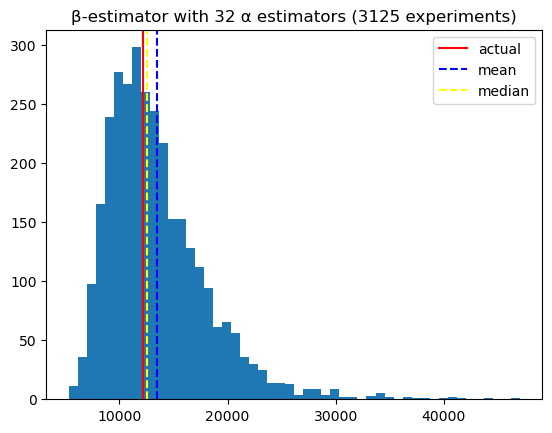

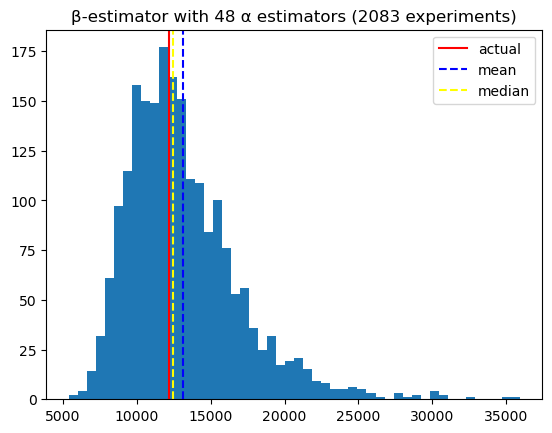

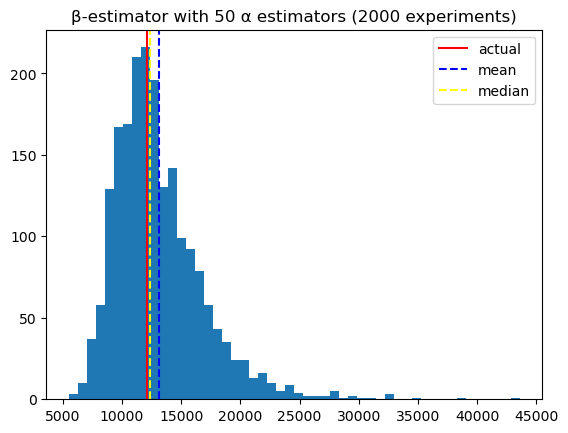

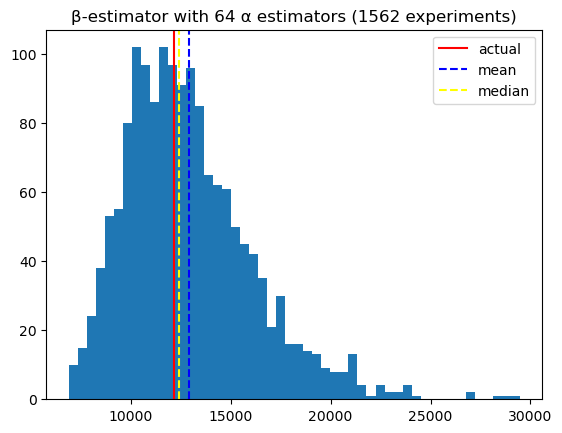

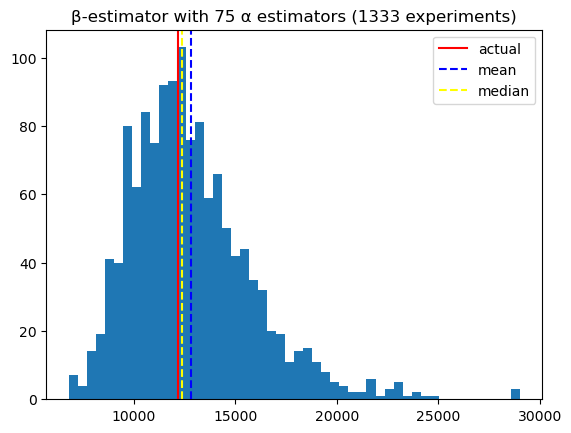

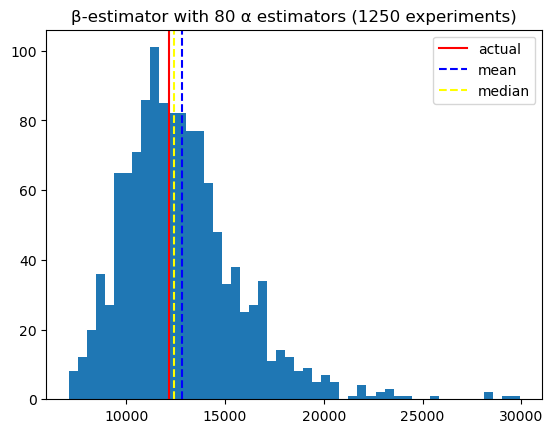

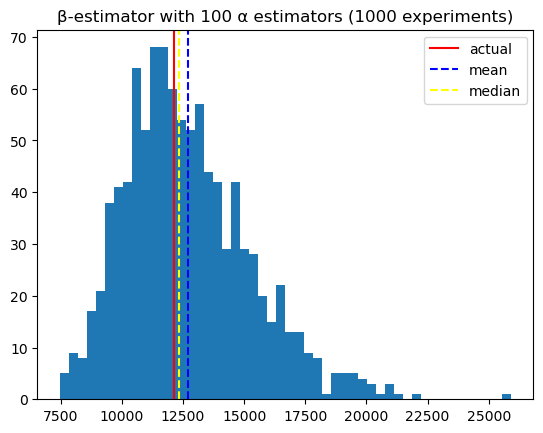

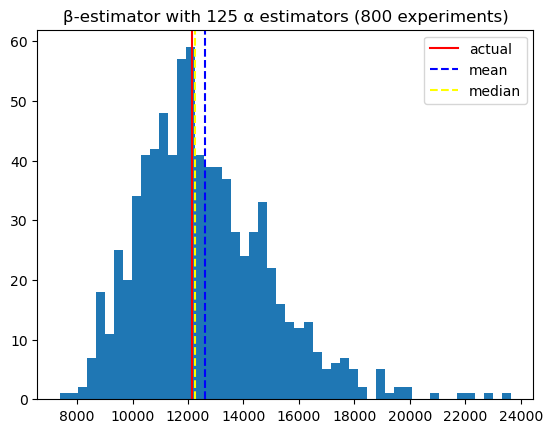

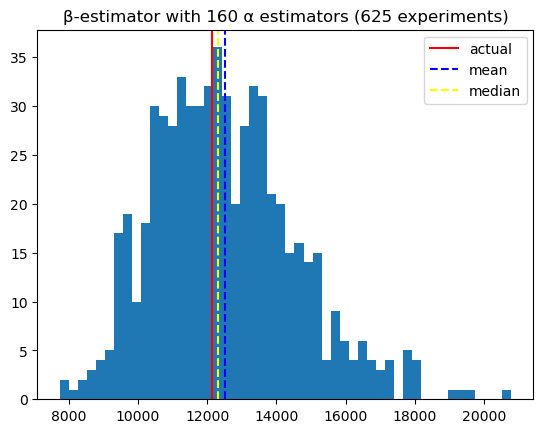

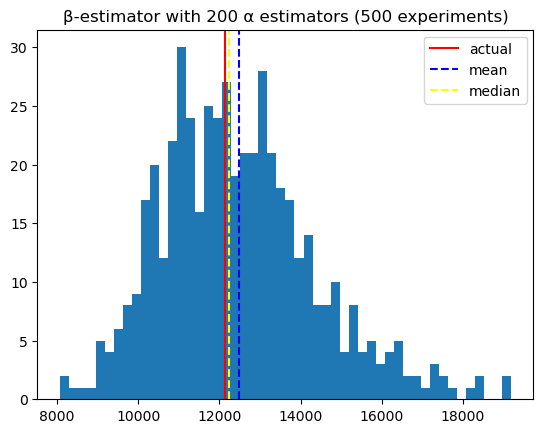

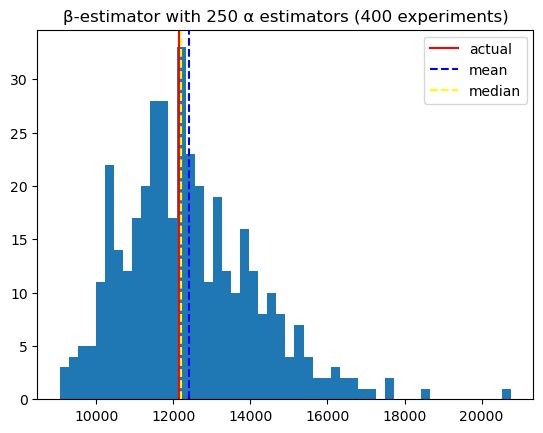

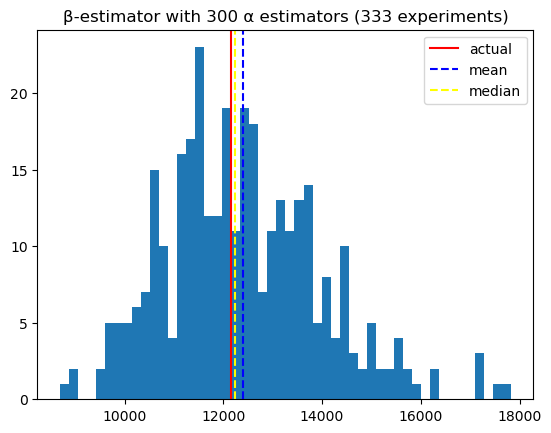

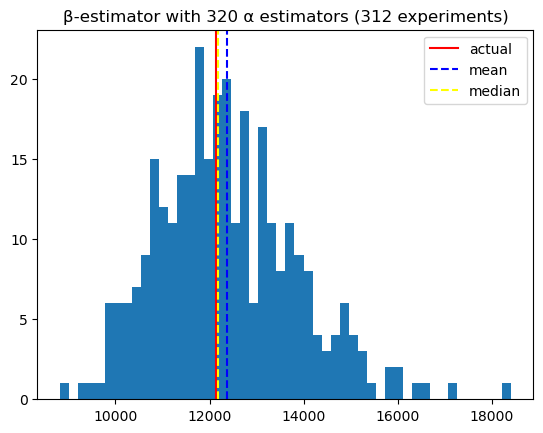

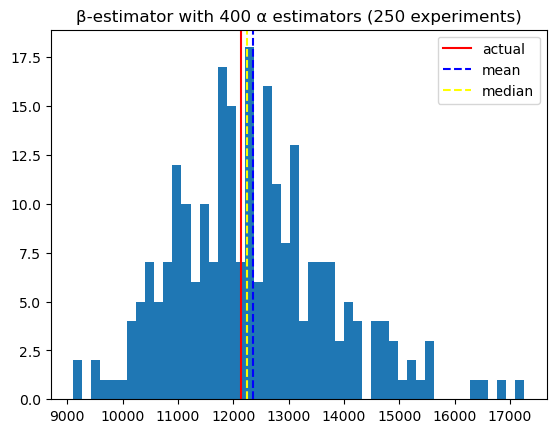

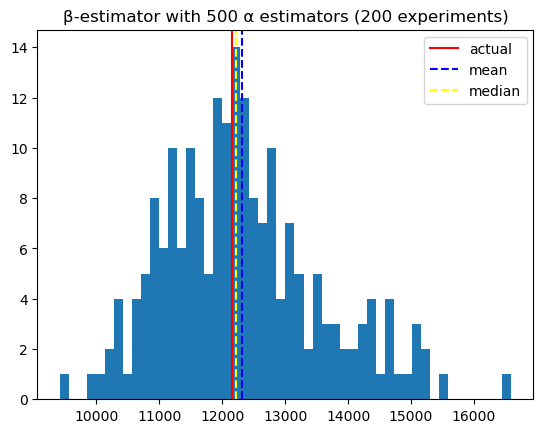

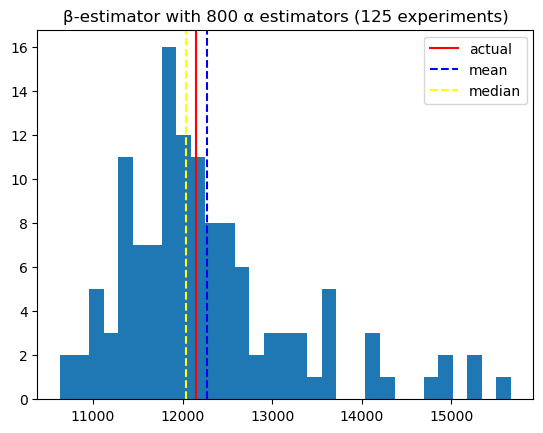

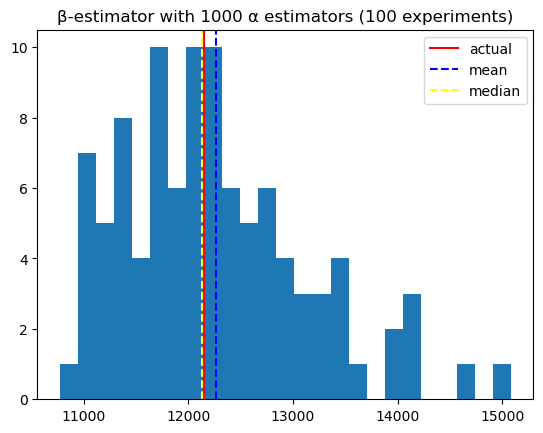

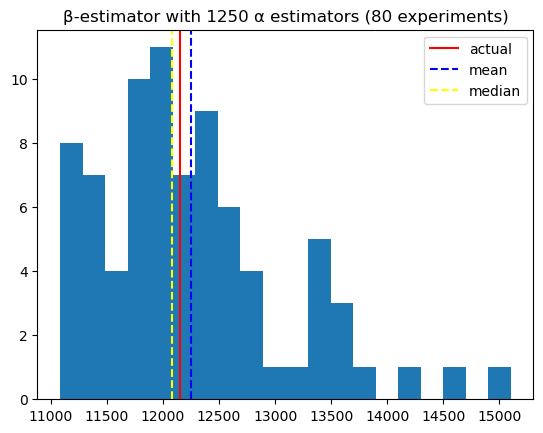

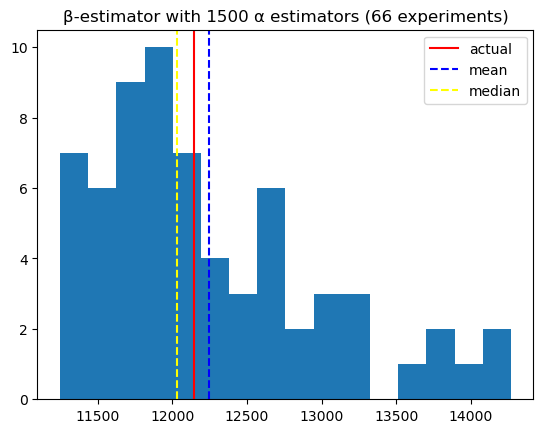

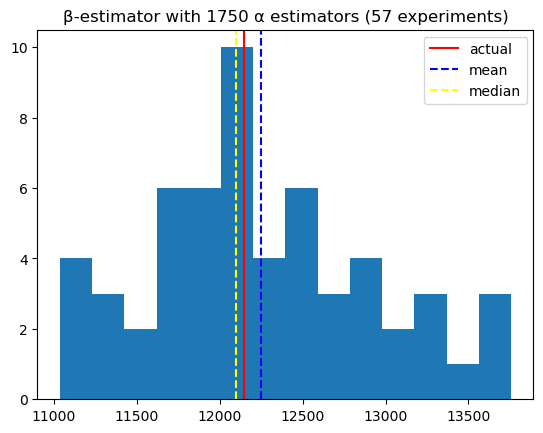

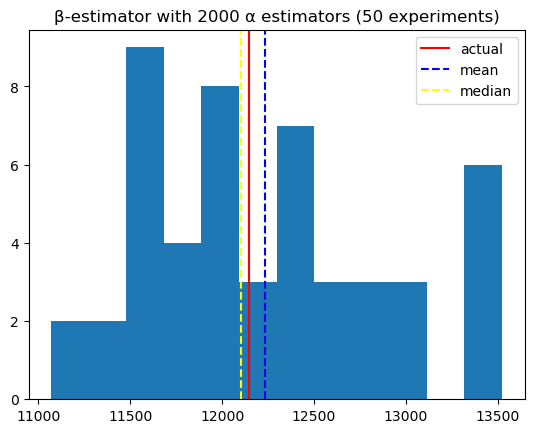

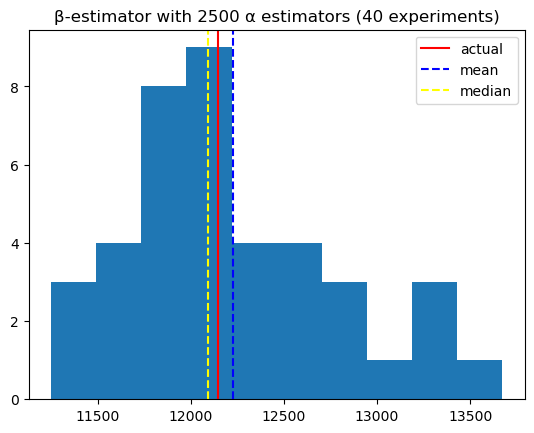

In [20]:
for n_hashes, b_res in sorted(beta_results.items()):
    fig = plt.figure()
    plt.hist(b_res, bins=min(50, len(b_res) // 4))
    plt.axvline(x=len(np.unique(X)), color='red', label='actual')
    plt.axvline(x=np.mean(b_res), color='blue', label='mean', linestyle='--')
    plt.axvline(x=np.median(b_res), color='yellow', label='median', linestyle='--')
    plt.title(f'β-estimator with {n_hashes} α estimators ({len(min_hashes_dict) // n_hashes} experiments)')
    plt.legend()
    plt.show()

### Mean as a function of the number of $\alpha$ estimators
We can see that the mean trends towards the actual value as the number of $\alpha$ estimators grows, which makes sense given what we learned in class

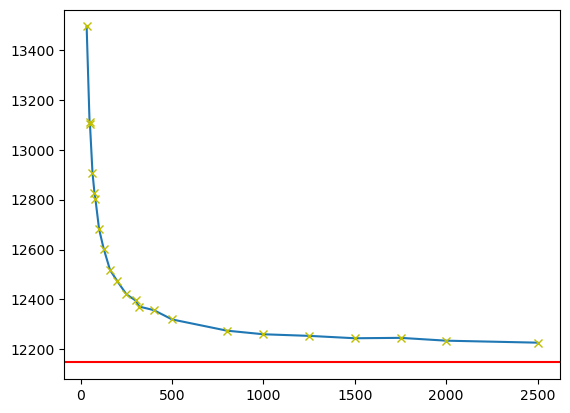

In [21]:
plt.plot(sorted(beta_results.keys()), [np.mean(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

### Median as a function of the number of $\alpha$ estimators
The median also trends towards the actual value as the number of $\alpha$ estimators grows, which is more interesting since this shows us what we could reasonably expect with the full FM estimator with 100 $\beta$ estimators

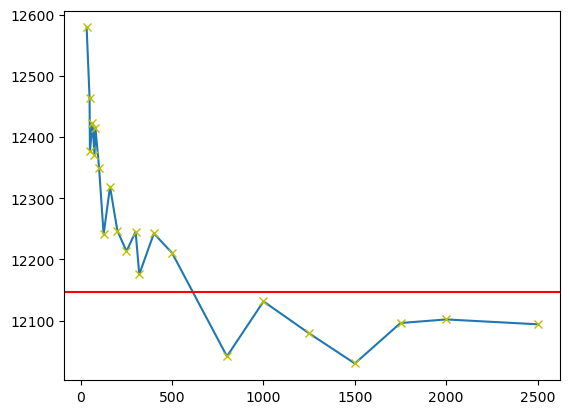

In [22]:
plt.plot(sorted(beta_results.keys()), [np.median(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

### Normalized Variance as a function of the number of $\alpha$ estimators
The normalized variance seems to decrease linearly as a function of the number of $\alpha$ estimators, which matches what we learned in class

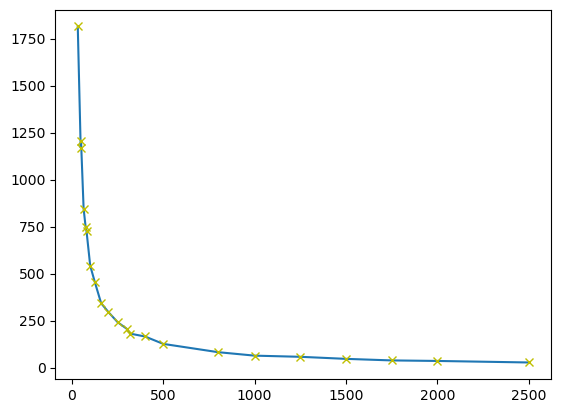

In [23]:
plt.plot(sorted(beta_results.keys()), [np.var(beta_results[k]) / len(np.unique(X)) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.show()

In [24]:
{k: np.var(val) / len(np.unique(X)) for k, val in beta_results.items()}

{32: np.float64(1814.557069031957),
 48: np.float64(1169.8510253325696),
 50: np.float64(1202.8346034191811),
 64: np.float64(844.9968088458944),
 75: np.float64(748.2448780489951),
 80: np.float64(725.1073271317241),
 100: np.float64(542.4938607528824),
 125: np.float64(455.85332850052356),
 160: np.float64(342.1611182057931),
 200: np.float64(294.8027743793373),
 250: np.float64(241.54744557828485),
 300: np.float64(206.29669976462264),
 320: np.float64(180.30486716906393),
 400: np.float64(165.2537618908726),
 500: np.float64(125.85773919985682),
 800: np.float64(81.82574011130812),
 1000: np.float64(63.372108354370866),
 1250: np.float64(57.205064949032156),
 1500: np.float64(46.26087374472826),
 1750: np.float64(37.98634363627599),
 2000: np.float64(35.154883062302595),
 2500: np.float64(27.01767702301793)}

## Full FM estimator


Here I ran a full FM estimator with 100 experiments with the following params:

| $\delta$ | $\epsilon$ | #$\beta$-estimators | Hash Functions |
|----------|------------|---------------------|----------------|
| 0.10     | 0.20       | 3                   | 58             |
| 0.05     | 0.20       | 3                   | 75             |
| 0.10     | 0.15       | 3                   | 103            |
| 0.01     | 0.20       | 5                   | 116            |
| 0.05     | 0.15       | 3                   | 134            |
| 0.01     | 0.15       | 5                   | 205            |
| 0.10     | 0.10       | 3                   | 231            |
| 0.05     | 0.10       | 3                   | 300            |
| 0.01     | 0.10       | 5                   | 461            |
| 0.10     | 0.05       | 3                   | 922            |
| 0.10     | 0.05       | 3                   | 1000           |
| 0.10     | 0.04       | 3                   | 1500           |
| 0.10     | 0.038      | 3                   | 2000           |
| 0.10     | 0.034      | 3                   | 2500           |

In [25]:
full_sketches = [(3, 58), (3, 75), (3, 103), (5, 116), (3, 134), (5, 205), (3, 231), (3, 300), (5, 461), (3, 922), (3, 1000),
                 (3, 1200), (3, 1500), (3, 1750), (3, 2000), (3, 2500)]

In [26]:
from typing import Iterable, Sequence, TypeVar

T = TypeVar("T")

def calculate_chunk_sizes(seq_len: int, num_chunks: int) -> list[int]:
    res = np.zeros(num_chunks).astype(int)
    cur_len = num_chunks
    num_left = seq_len

    while np.sum(res) < seq_len:
        addition = num_left // cur_len
        if np.sum(res) + addition * cur_len <= seq_len:
            res[np.arange(cur_len)] += addition
            num_left -= addition * cur_len
        cur_len -= 1

    return res.tolist()

def chunk(vals: Sequence[T], num_chunks: int) -> Iterable[Sequence[T]]:
    cur_start = 0
    for chunk_size in calculate_chunk_sizes(len(vals), num_chunks):
        yield vals[cur_start:cur_start+chunk_size]
        cur_start += chunk_size

In [27]:
def full_fm_experiment(experiment_seed: int, num_betas: int, num_hash_funcs: int) -> float:
    min_hashes = [min_hashes_dict[i + experiment_seed * num_hash_funcs] for i in range(num_hash_funcs)]
    sub_betas = [1 / np.mean(beta_hashes) - 1 for beta_hashes in chunk(min_hashes, num_betas)]
    return float(np.median(sub_betas))

In [28]:
full_fm_results = {
    (n_betas, sketch_size): [full_fm_experiment(base_seed, n_betas, sketch_size) for base_seed in range(len(min_hashes_dict) // sketch_size)]
    for n_betas, sketch_size in full_sketches
}

In [29]:
sorted_full_fm_res = sorted(full_fm_results.items(), key=lambda x: x[0][1])

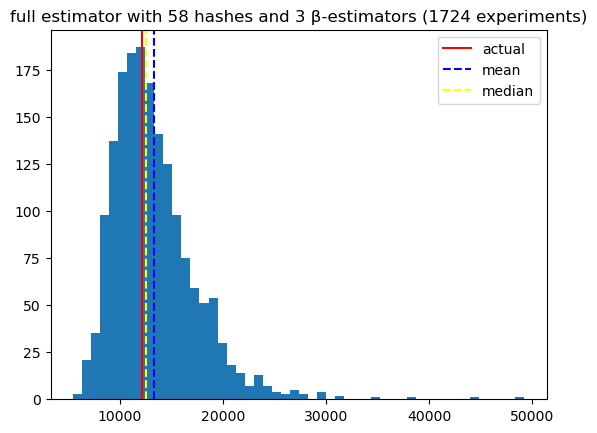

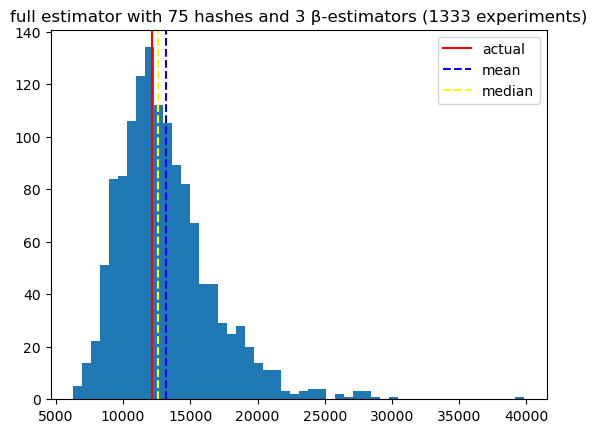

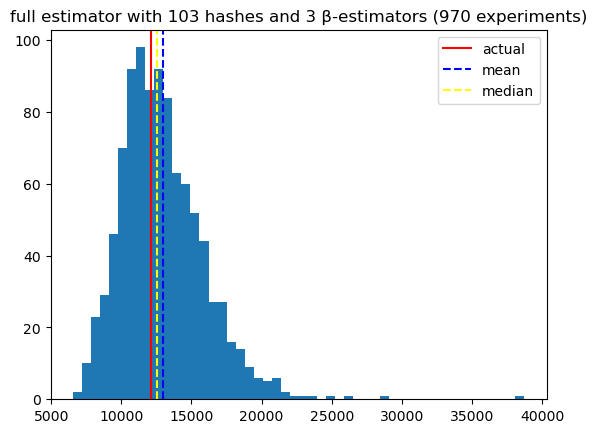

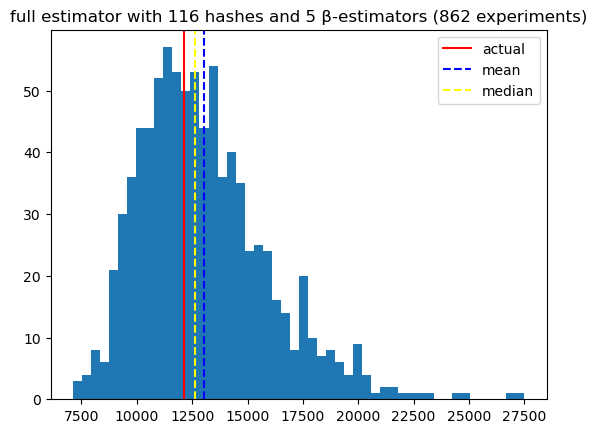

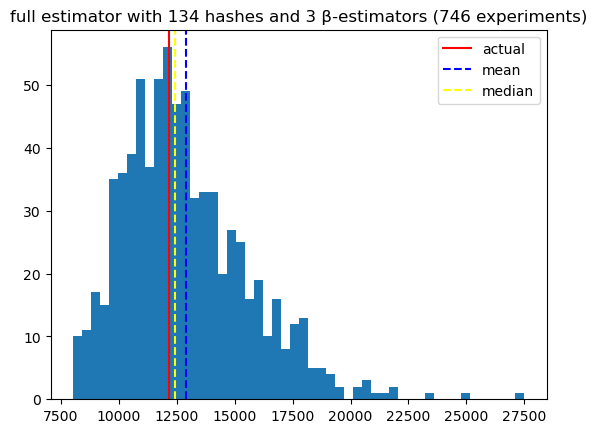

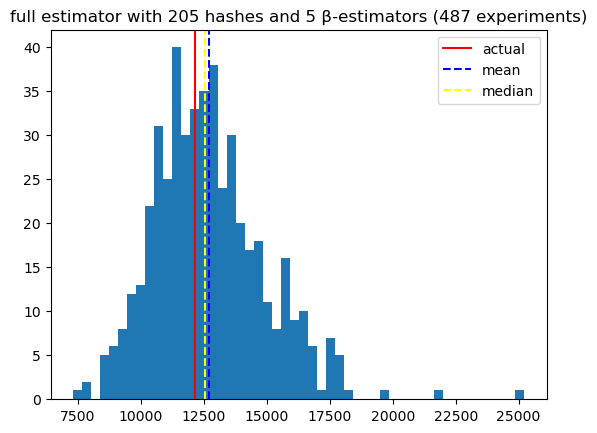

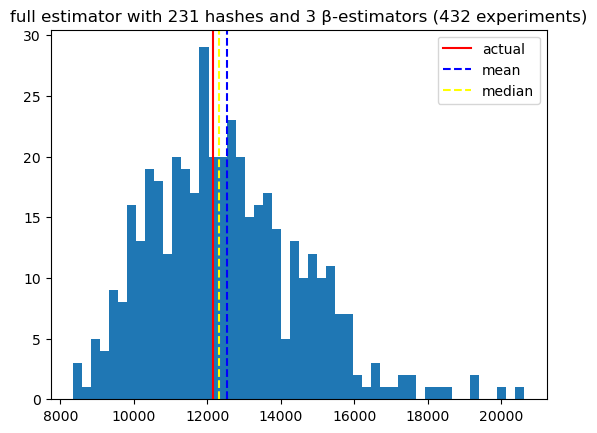

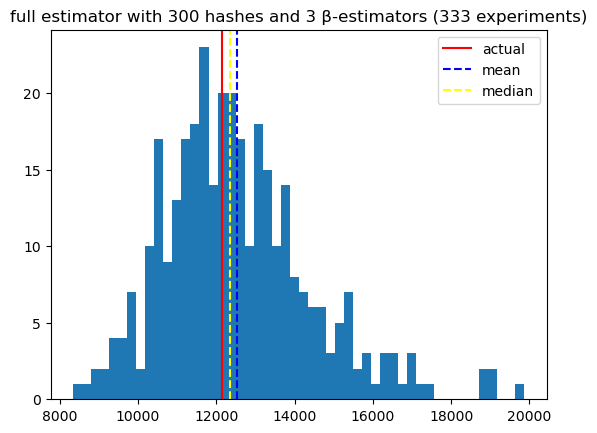

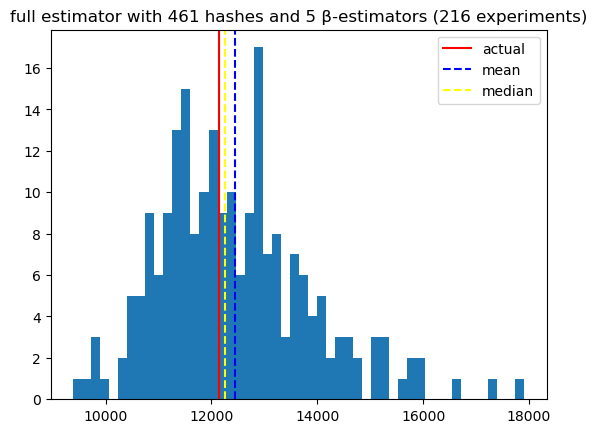

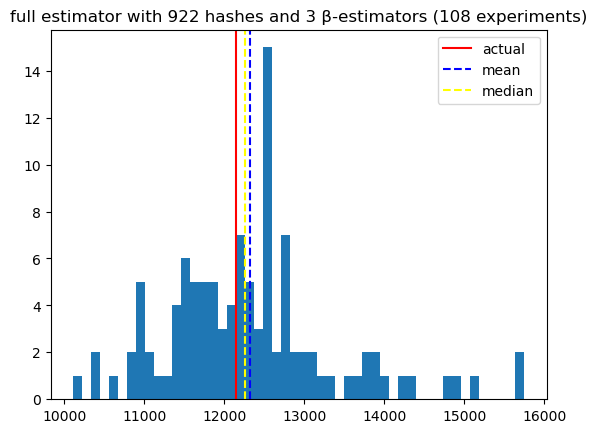

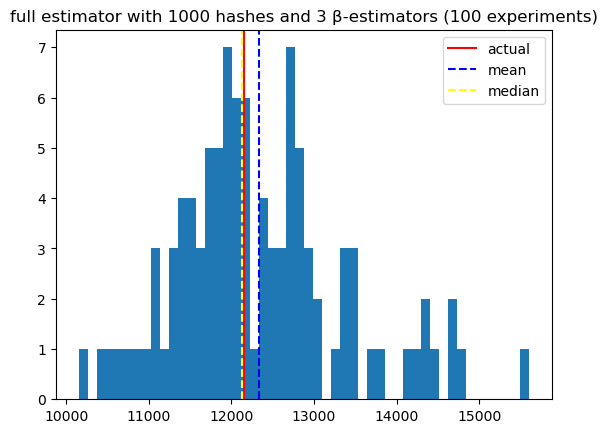

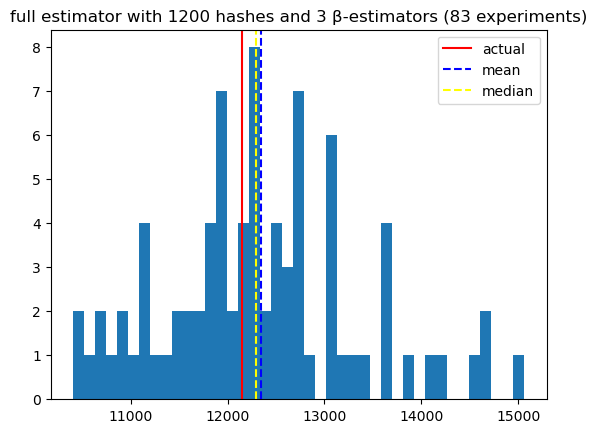

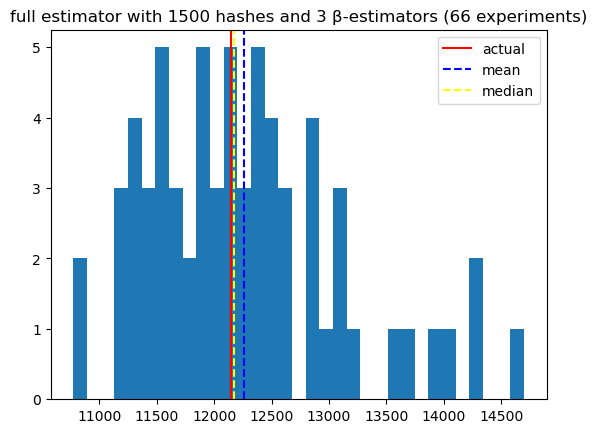

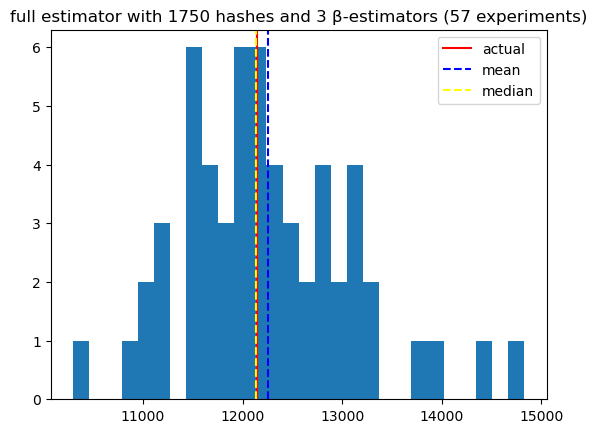

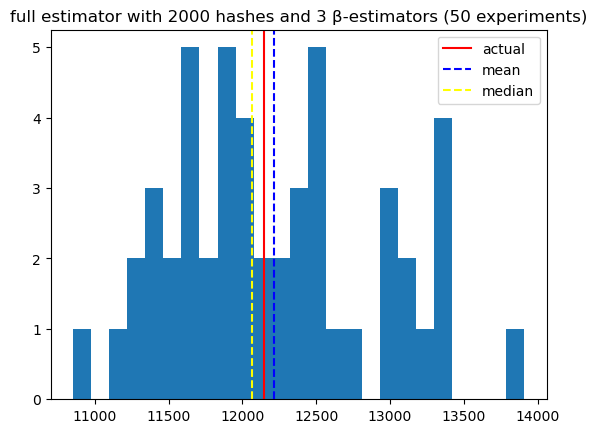

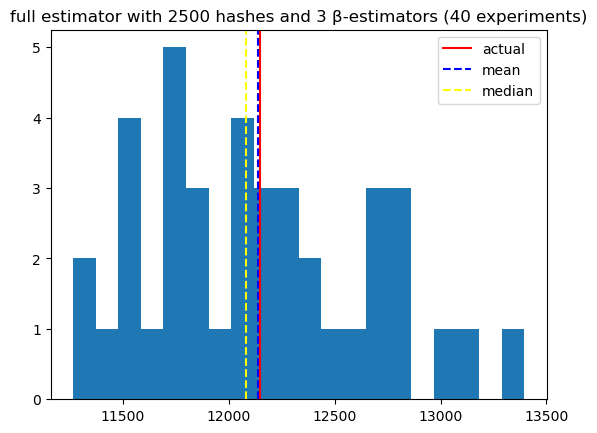

In [30]:
for (n_betas, n_hashes), b_res in sorted_full_fm_res:
    fig = plt.figure()
    plt.hist(b_res, bins=min(50, len(b_res) // 2))
    plt.axvline(x=len(np.unique(X)), color='red', label='actual')
    plt.axvline(x=np.mean(b_res), color='blue', label='mean', linestyle='--')
    plt.axvline(x=np.median(b_res), color='yellow', label='median', linestyle='--')
    plt.title(f'full estimator with {n_hashes} hashes and {n_betas} β-estimators ({len(min_hashes_dict) // n_hashes} experiments)')
    plt.legend()
    plt.show()

In [31]:
[f'{n_hashes=}, {n_betas=}: median={float(np.median(b_res))}, diff={abs(float(np.median(b_res)) - len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: median=12595.512484669538, diff=448.512484669538',
 'n_hashes=75, n_betas=3: median=12616.644030987616, diff=469.64403098761613',
 'n_hashes=103, n_betas=3: median=12529.372789467405, diff=382.3727894674048',
 'n_hashes=116, n_betas=5: median=12609.542817048474, diff=462.5428170484738',
 'n_hashes=134, n_betas=3: median=12404.96078859338, diff=257.96078859338013',
 'n_hashes=205, n_betas=5: median=12534.328912654104, diff=387.328912654104',
 'n_hashes=231, n_betas=3: median=12322.484217021567, diff=175.48421702156702',
 'n_hashes=300, n_betas=3: median=12339.29983223344, diff=192.2998322334406',
 'n_hashes=461, n_betas=5: median=12262.533697939469, diff=115.53369793946877',
 'n_hashes=922, n_betas=3: median=12261.524247486912, diff=114.52424748691192',
 'n_hashes=1000, n_betas=3: median=12131.855749979622, diff=15.144250020377513',
 'n_hashes=1200, n_betas=3: median=12288.813533613466, diff=141.81353361346555',
 'n_hashes=1500, n_betas=3: median=12168.83330433

In [32]:
[f'{n_hashes=}, {n_betas=}: mean={float(np.mean(b_res))}, diff={abs(float(np.mean(b_res)) - len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: mean=13352.009806105374, diff=1205.009806105374',
 'n_hashes=75, n_betas=3: mean=13180.137864291053, diff=1033.1378642910531',
 'n_hashes=103, n_betas=3: mean=12945.451890706305, diff=798.4518907063048',
 'n_hashes=116, n_betas=5: mean=13039.57011369939, diff=892.5701136993903',
 'n_hashes=134, n_betas=3: mean=12886.718239247137, diff=739.7182392471368',
 'n_hashes=205, n_betas=5: mean=12704.72875359516, diff=557.72875359516',
 'n_hashes=231, n_betas=3: mean=12521.327321941882, diff=374.3273219418825',
 'n_hashes=300, n_betas=3: mean=12533.271736647193, diff=386.2717366471934',
 'n_hashes=461, n_betas=5: mean=12439.370353577871, diff=292.37035357787136',
 'n_hashes=922, n_betas=3: mean=12321.613749474483, diff=174.61374947448348',
 'n_hashes=1000, n_betas=3: mean=12335.362797405216, diff=188.36279740521604',
 'n_hashes=1200, n_betas=3: mean=12344.536296337974, diff=197.5362963379739',
 'n_hashes=1500, n_betas=3: mean=12261.160789889906, diff=114.16078988990557

In [33]:
[f'{n_hashes=}, {n_betas=}: norm var={float(np.var(b_res) / len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: norm var=1346.0268958548272',
 'n_hashes=75, n_betas=3: norm var=1031.8705762888255',
 'n_hashes=103, n_betas=3: norm var=740.0097517620742',
 'n_hashes=116, n_betas=5: norm var=702.4077767644457',
 'n_hashes=134, n_betas=3: norm var=600.6531391766944',
 'n_hashes=205, n_betas=5: norm var=402.34602767814494',
 'n_hashes=231, n_betas=3: norm var=347.61340108483415',
 'n_hashes=300, n_betas=3: norm var=296.4615991760324',
 'n_hashes=461, n_betas=5: norm var=170.68628271331514',
 'n_hashes=922, n_betas=3: norm var=91.15620560089104',
 'n_hashes=1000, n_betas=3: norm var=87.37341103319123',
 'n_hashes=1200, n_betas=3: norm var=82.49601016020758',
 'n_hashes=1500, n_betas=3: norm var=60.291608801227255',
 'n_hashes=1750, n_betas=3: norm var=61.16517223166758',
 'n_hashes=2000, n_betas=3: norm var=39.35896909291429',
 'n_hashes=2500, n_betas=3: norm var=22.469259775250418']

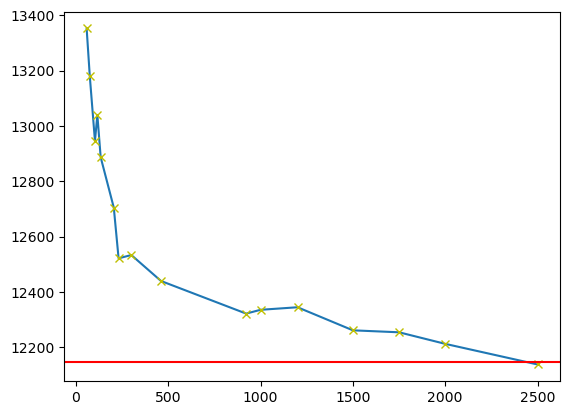

In [34]:
plt.plot(
    [sketch_size for (_, sketch_size), _ in sorted_full_fm_res],
    [np.mean(fm_res) for _, fm_res in sorted_full_fm_res], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

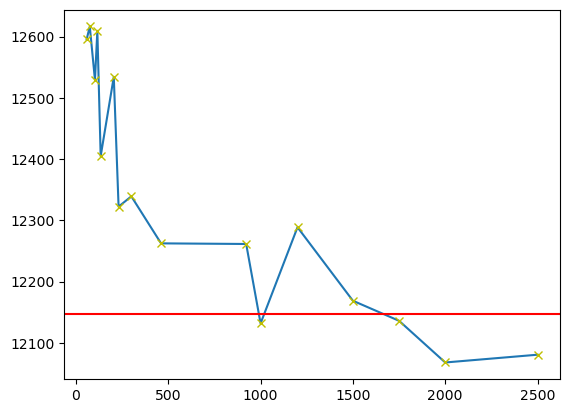

In [35]:
plt.plot(
    [sketch_size for (_, sketch_size), _ in sorted_full_fm_res],
    [np.median(fm_res) for _, fm_res in sorted_full_fm_res], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

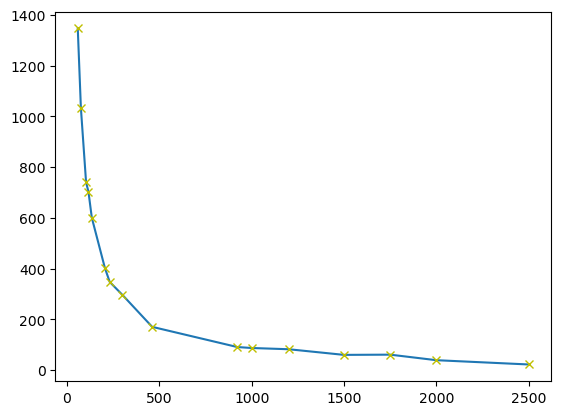

In [36]:
plt.plot(
    [sketch_size for (_, sketch_size), _ in sorted_full_fm_res],
    [np.var(fm_res) / len(np.unique(X)) for _, fm_res in sorted_full_fm_res], marker='x', mec='y')
plt.show()

In [40]:
np.mean([full_fm_experiment(base_seed, 4, 2500) for base_seed in range(40)])

np.float64(12192.17403788985)

In [38]:
len(np.unique(X))

12147